# Simulation Code

In [24]:
import jax.numpy as np
import numpy as onp
from jax.lax import cond
from jax import vmap,jit,random,grad,value_and_grad
from functools import partial
from jax.scipy.stats.norm import pdf,cdf,ppf
from bisect import bisect_left as bl
import matplotlib.pyplot as plt


from jax import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans",False)

plt.rcParams["text.usetex"] = True



### For Debugging

In [25]:

debug = False
if debug: # a non-accelerated version of jax.lax.scan for testing purposes
  def scan(f,c0,xs=None,length = 1):
    if xs is None:
      xs = [None]*length
    c = c0
    ys = []
    for x in xs:
      c,y = f(c,x)
      ys.append(y)
    ds = []
    try:
      _ = iter(ys[0])
      for i in range(len(ys[0])):
        d = []
        for j in range(len(ys)):
          d.append(ys[j][i])
        ds.append(np.array(d))
    except:
      ds = np.array(ys)
    return c,ds
      
else:
  from jax.lax import scan
  from jax import jit

## Simulation Classes

### Support functions

In [26]:

def ker(x):
  return np.exp(-x@x/2)*((2*np.pi)**(-len(x)/2))

def logker(x,h):
  return -x@x/2/h**2 - len(x)/2*np.log(2*np.pi*h**2)


@jit
def eval_kde(y,xs,h):
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return np.exp(pref)*np.mean(np.exp(logkers))

@jit
def logpdf(y,xs,h):
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return pref + np.log(np.mean(np.exp(logkers)))

@jit
def logl(ys,xs,h):
  def sf(s,y):
    s = s + logpdf(y,xs,h)
    return s,None
  S,_ = scan(sf,0.,ys)
  return S

@jit #Flag, JAX may not like this!
def dxkde(y,xs,h):
  def sf(s,z):
    s = s - z*ker(z)
    return s,None
  S,_ = scan(sf,np.zeros(len(y)),(y-xs)/h)
  return S/len(xs)/h**(len(y)+1)

@jit
def entaprx(ys,xs,h,lyCut):
  def sf(s,y):
    l = logpdf(y,xs,h)
    l = cond(np.isinf(l),lambda x: 0.,lambda x: l,None)
    s += l*(1 + np.sign(l-lyCut))/2
    return s,None
  S,_ = scan(sf,0.,ys)
  return -S/len(ys)

@partial(jit,static_argnums = (5,))
def opt(h,xmle,xkde,dh0,scale = 1/np.sqrt(2),nSteps = 100):
  def sc(c,n):
    h,v,dh = c
    vp = logl(xmle,xkde,h+dh)
    vm = logl(xmle,xkde,h-dh)
    nh,nv = cond(v < vp,lambda x: (h+dh,vp),lambda x: (h,v),None)
    nh,nv = cond(nv < vm,lambda x: (h-dh,vm),lambda x: (nh,nv),None)
    dh = cond(v == nv,lambda x: dh*scale,lambda x: dh,None)
    return (nh,nv,dh),None
  c,_ = scan(sc,(h,logl(xmle,xkde,h),dh0),None,length = nSteps)
  h,_,dh = c
  return h,dh

def indc(x):
  return 1/2*(1 + np.sign(x))

@jit
def bDiff(x):
  x = x.at[1:].set(x[1:]-x[:-1])
  return x

@jit
def fDiff(x):
  x = x.at[:-1].set(x[1:]-x[:-1])
  x = x.at[-1].set(-x[-1])
  return x

@jit
def diff2(x):
  x0 = x[0]
  x = bDiff(fDiff(x))
  x = x.at[0].set(x[0] - x0)
  return x


@partial(jit,static_argnums = (0,))
def rk4Step(f,x,y,t,dt):
  kx1,ky1 = f(x,y,t)
  kx2,ky2 = f(x + kx1*dt/2,y + ky1*dt/2,t + dt/2)
  kx3,ky3 = f(x + kx2*dt/2,y + ky2*dt/2,t + dt/2)
  kx4,ky4 = f(x + kx3*dt,y + ky3*dt,t + dt)
  return x + dt/6 *(kx1 + 2*kx2 + 2*kx3 + kx4),y + dt/6 *(ky1 + 2*ky2 + 2*ky3 + ky4)




### Langevin Dynamics

In [27]:

class Langevin:
  def __init__(self,param0 = {"eta":1.,"beta":1.,"l1":1.,"l2":1.5,"a":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def v(self,x):
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def f(self,x): #pairwise interaction force
    return self.a*x*(x + self.l1)*(x - self.l2)

  def V(self,x,t):
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    return np.sum(vmap(self.v)(dx))

  def F(self,x,t):
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    Fs = vmap(self.f)(dx)
    return Fs[1:] - Fs[:-1]

  def fEx(self,x,t):
    return self.f(self.ell(t) - x[-1])

  def dx(self,key,xs,t,dt):
    f = vmap(self.F,in_axes = (0,None))(xs,t)
    key,k1 = random.split(key)
    bm = random.normal(k1,xs.shape)
    return key,f*dt/self.eta + np.sqrt(2*dt/self.eta/self.beta)*bm

  def dW(self,xs,t,dt):
    fex = vmap(self.fEx,in_axes = (0,None))(xs,t)
    return fex*grad(self.ell)(t)*dt


  @partial(jit,static_argnums = (0,6))
  def run(self,key,x0s,t0,W0,dt,nSteps):
    def func(carry,n):
      k0,x,t,W = carry
      k0,dx = self.dx(k0,x,t,dt)
      dW = self.dW(x,t,dt)
      carry = k0,x+dx,t+dt,W+dW
      return carry,None
    c0 = key,x0s,t0,W0
    out,_ = scan(func,c0,None,length = nSteps)
    key,x1,t1,W1 = out
    return key,x1,t1,W1

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,key,x0s,t0,W0,dt,nSteps,nLeap):
    def sf(c,n):
      key,x,t,W = c
      c = self.run(key,x,t,W,dt,nLeap)
      return c,c
    c0 = key,x0s,t0,W0
    _,out = scan(sf,c0,None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,))
  def entropy(self,xmle,xkde,xeval,h0):
    h,_ = opt(h0,xmle,xkde,0.05,nSteps = 10)
    return entaprx(xeval,xkde,h,-np.log(len(xkde))/np.log(10)*3)

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,xmles,xkdes,xevals,ts,Ws,h0=0.2):
    xs = np.concatenate((xmles,xkdes,xevals),axis = 1)
    dt = ts[1] - ts[0]
    Vs = np.mean(vmap(vmap(self.V,in_axes = (0,None)),in_axes = (0,0))(xs,ts),axis = -1)
    Ws = np.mean(Ws,axis = -1)
    Vs = Vs.at[1:].set(Vs[1:] - Vs[:-1])/dt
    Ws = Ws.at[1:].set(Ws[1:] - Ws[:-1])/dt
    def sf(n,i):
      out = self.entropy(xmles[i],xkdes[i],xevals[i],h0)
      return None,out
    _,ents = scan(sf,None,np.arange(xmles.shape[0]))
    ents = ents.at[1:].set(ents[1:] - ents[:-1])/self.beta
    return (Ws - Vs),ents

  def phases(self,xs,ts):
    # ts,nSamps,dim
    augxs = np.zeros((xs.shape[0],xs.shape[1],xs.shape[2]+2))
    augxs = augxs.at[:,:,1:-1].set(xs)
    augxs = augxs.at[:,:,-1].set((np.ones((xs.shape[1],xs.shape[0]))*self.ell(ts)).T)
    dx = augxs[:,:,1:] - augxs[:,:,:-1]
    return np.sum(dx > 0.,axis = 1)/dx.shape[1]

  def getFrontLoc(self,xs,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)

### Exact STIV

In [28]:
class STIVExact:
  def __init__(self,param0 = {"eta":1.,"beta":1.,"l1":1.,"l2":1.5,"a":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def v(self,x):
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def f(self,x): #pairwise interaction force # v'
    return self.a*x*(x + self.l1)*(x - self.l2)


  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    # next we compute eps and tau
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    dAdeps = self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)))
    dAdtau = self.a*(tau*(3*eps**2 + 2*(self.l1 - self.l2)*eps - self.l1*self.l2) + 3*tau**3)
    muDot = -1/self.eta * ( dAdeps[:-1] - dAdeps[1:])
    sDot = -1/self.eta*s*(dAdtau[:-1]/tau[:-1] + dAdtau[1:]/tau[1:]) + self.D/s
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    def sf(c,n):
      mu,s,t = c
      mu,s,t = self.step(mu,s,t,dt)
      c = mu,s,t
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  def entropyProduction(self,mu,s,t):
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot@muDot + sDot@sDot)

  def fEx(self,mu,s,t):
    eps = self.ell(t) - mu[-1]
    tau = s[-1]
    return self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)))

  def phase(self,mu,s,t):
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)




### STIV with Gauss-Hermite Integration

In [29]:
class STIVgh: # This is going to be a quartic example
  def __init__(self,param0 = {"a":1.,"l1":1.,"l2":1.,"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def du(self,x):
    return self.a*x*(x + self.l1)*(x - self.l2)

  def F(self,m,s):
    ws = np.array([5.079294790166e-1,
        2.806474585285e-1,
        8.381004139899e-2,
        1.288031153551e-2,
        9.322840086242e-4,
        2.711860092538e-5,
        2.320980844865e-7,
        2.654807474011e-10])
    xs = np.array([0.27348104613815,
        0.82295144914466,
        1.38025853919888,
        1.95178799091625,
        2.54620215784748,
        3.17699916197996,
        3.86944790486012,
        4.68873893930582])
    ws = np.concatenate((ws[::-1],ws))
    xs = np.concatenate((-xs[::-1],xs))
    return np.sum(-self.du(np.sqrt(2)*s*xs + m)*ws)/np.sqrt(np.pi)

  def dFdm(self,m,s):
    h = 0.001
    fm2 = self.F(m-2*h,s)
    fm1 = self.F(m-h,s)
    f1 = self.F(m+h,s)
    f2 = self.F(m+2*h,s)
    return (fm2/12 - 2/3*fm1 + 2/3*f1 - f2/12)/h


  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (0,0))(eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (0,0))(eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (0,0))(eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (0,0))(eps[1:],tau[1:]) + 1/self.beta/s**2)
    dAdeps = self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)) )
    dAdtau = self.a*(tau*(3*eps**2 + 2*(self.l1 -self.l2)*eps - self.l1*self.l2) + 3*tau**3)
    muDot1 = -1/self.eta * (dAdeps[:-1] - dAdeps[1:])
    sDot1 = -s/self.eta * (dAdtau[:-1]/tau[:-1] + dAdtau[1:]/tau[1:]) + self.D/s
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  def fEx(self,mu,s,t):
    return -self.F(self.ell(t) - mu[-1],s[-1])

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)


  def phase(self,mu,s,t):
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


### STIV with sampling

In [30]:
class STIVSampling: # This is going to be a quartic example
  def __init__(self,param0 = {"a":1.,"l1":1.,"l2":1.,"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    self.f = np.zeros((1,1)) # Store the coeffs for an approximate free energy
    return

  @partial(jit,static_argnums = (0,))
  def u(self,x):
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def du(self,x):
    return self.a*x*(x + self.l1)*(x - self.l2)


  def makeAprxF(self,key,muBound,sBound,ChevOrder,muOrder,sOrder,nSamples):
    # this function will construct the self.C to be used in future approximations
    muChev = (muBound[1] - muBound[0])/2 * (np.cos(np.pi * np.arange(1,ChevOrder + 2)/(ChevOrder + 2))[::-1] + 1) + muBound[0]
    sChev = (sBound[1] - sBound[0])/2 * (np.cos(np.pi * np.arange(1,ChevOrder + 1)/(ChevOrder + 1))[::-1] + 1) + sBound[0]
    M,S = np.meshgrid(muChev,sChev)
    FS = -np.mean(self.du(random.normal(key,shape = (nSamples,M.shape[0],M.shape[1]))*S + M),axis = 0)
    M = (np.ones((muOrder + 1,ChevOrder + 1))*muChev).T **(np.arange(muOrder + 1))
    S = (np.ones((sOrder  + 1,ChevOrder    ))*sChev).T **(np.arange(sOrder + 1))
    A,x,Bt = np.linalg.svd(M,full_matrices = False)
    M = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    A,x,Bt = np.linalg.svd(S,full_matrices = False)
    S = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    self.f = M @ FS.T @ S.T
    return self.f

  @partial(jit,static_argnums = (0,))
  def F(self,f,m,s):
    return (m**np.arange(f.shape[0])) @ f @ (s**np.arange(f.shape[1]))

  def checkConsistency(self,mus,ss,ts,muBound,sBound):
    fig,ax = plt.subplots(1,1,figsize = (16,9))
    mPnts = np.linspace(muBound[0],muBound[1],100)
    sPnts = np.linspace(sBound[0],sBound[1],100)
    M,S = np.meshgrid(mPnts,sPnts)
    FS = (vmap(self.F,in_axes = (None,0,0))(self.f,M.flatten(),S.flatten())).reshape(M.shape)
    ax.contourf(M,S,FS,cmap = "terrain",levels = 50)

    eps = np.zeros((mus.shape[0],mus.shape[1] + 2))
    eps = eps.at[:,1:-1].set(mus)
    eps = eps.at[:,-1].set(self.ell(ts))
    eps = eps[:,1:] - eps[:,:-1]
    tau = np.zeros((ss.shape[0],ss.shape[1] + 2))
    tau = tau.at[:,1:-1].set(ss**2)
    tau = np.sqrt(tau[:,1:] + tau[:,:-1])

    ax.scatter(eps.flatten(),tau.flatten(),marker = "x",color = "r")  
    plt.show()
    plt.close(fig)
    return

    
  @partial(jit,static_argnums =(0,))
  def dFdm(self,f,m,s):
    return (np.arange(1,f.shape[0])*m**(np.arange(f.shape[0]-1))) @ f[1:,:] @ (s**np.arange(f.shape[1]))

  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]) + 1/self.beta/s**2)
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out


  def fEx(self,mu,s,t):
    return -self.F(self.f,self.ell(t) - mu[-1],s[-1])


  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)

  def phase(self,mu,s,t):
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


### Phase Field Code

In [31]:
class PhaseField:
  def __init__(self,param0 = {"eta":1.,"beta":1.,"l1":1.,"l2":1.5,"a":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    #self.pBest = np.array([14.15650696,   0.08807741,   0.06584528,  32.43906193])
    self.factors = np.array([1.64380512e+01, 2.34840455e-01, 7.25725500e-02, 1.21791220e+02])
    self.pBest = np.array([2.3470819,  0.04619807, 0.03984329, 6.40126227])
    self.bestLoss = 0.022691957115568536
    return

  @partial(jit,static_argnums = (0,))
  def velocity(self,eps,phi,ell): # eps is length n, phi is length n+1
    eeps = np.zeros(len(eps) + 1)
    eeps = eeps.at[:-1].set(eps)
    eeps = eeps.at[-1].set(ell - np.sum(eps))


    phaseWidth = self.factors[0]*self.pBest[0]
    phaseBarrier = self.factors[1]*self.pBest[1]
    phaseInvDiffusivity = self.factors[2]*self.pBest[2]
    ae = self.factors[3]*self.pBest[3]

    h = phaseBarrier
    kappa = phaseWidth**2 * phaseBarrier
    ap = 1/phaseInvDiffusivity/phaseWidth**2/phaseBarrier

  
    a = self.a
    l1 = self.l1
    l2 = self.l2
    k1 = l1*(l1+l2)
    k2 = l2*(l1+l2)
    h2 = -l2**3/6 * (l2/2 + l1) 
    h1 = - l1**3/6*(l1/2 + l2)

    n = phi.shape[0]

    D2 = -2*np.diag(np.ones(n)) + np.diag(np.ones(n-1),1) + np.diag(np.ones(n-1),-1) # Dirichlet boundary conditions
    D2n = D2.at[0,0].set(-1.)
    D2n = D2.at[-1,-1].set(-1.) # using Nuemann boundary conditions
    qPhi = phi**3*(10 - 15*phi + 6*phi**2)
    dqPhi = 30.0*phi**2*(phi - 1.)**2
    dwPhi = 32.0*(phi - 3*phi**2 + 2*phi**3) 
  
 
    deps = (ae*D2 @ (a*k1*(eeps + l1) + (a*k2*(eeps - l2) - a*k1*(eeps + l1))*qPhi))[:-1] # quadratic fit via Taylor expansion about minima
    dphi = -ap*( dqPhi*( a*k2/2*(eeps - l2)**2 - a*k1/2*(eeps + l1)**2 + a*(h2 - h1)) + h*dwPhi - kappa*D2n@phi)  # quadrtic by hnd
 
    return deps,dphi

  @partial(jit,static_argnums = (0,))
  def rk4Step(self,eps,phi,ell0,ell1,ell2,dt):
    de1,dp1 = self.velocity(eps,phi,ell0)
    de2,dp2 = self.velocity(eps + de1*dt/2,phi + dp1*dt/2,ell1)
    de3,dp3 = self.velocity(eps + de2*dt/2,phi + dp2*dt/2,ell1)
    de4,dp4 = self.velocity(eps + de3*dt,phi + dp3*dt,ell2)
    return eps + dt/6*(de1 + 2*de2 + 2*de3 + de4),phi + dt/6*(dp1 + 2*dp2 + 2*dp3 + dp4)



  @partial(jit,static_argnums = (0,-1,))
  def getTraj(self,_e0,_p0,ells,dt,N): # NOTE: len(ells) = N*(len(ts) - 1)
    e0 = _e0
    p0 = cond(np.all(_p0 == 0.),lambda n: _p0.at[-1].set(0.01),lambda n: _p0,None)
    def sf(c,ls):
      e0,p0 = c
      e0,p0 = self.rk4Step(e0,p0,ls[0],ls[1],ls[2],dt)
      o = e0,p0
      return o,c 
    fVal,vals = scan(sf,(e0,p0),ells)
    es,ps = vals
    es = np.concatenate((es,np.array([fVal[0],])))
    ps = np.concatenate((ps,np.array([fVal[1],])))
    return es,ps

  def freeEnergy(self,eps,phi,ell):
    eeps = np.zeros(len(eps) + 1)
    eeps = eeps.at[:-1].set(eps)
    eeps = eeps.at[-1].set(ell - np.sum(eps))


    phaseWidth = self.factors[0]*self.pBest[0]
    phaseBarrier = self.factors[1]*self.pBest[1]
    phaseInvDiffusivity = self.factors[2]*self.pBest[2]
    ae = self.factors[3]*self.pBest[3]

    h = phaseBarrier
    kappa = phaseWidth**2 * phaseBarrier
    ap = 1/phaseInvDiffusivity/phaseWidth**2/phaseBarrier

    a = self.a
    l1 = self.l1
    l2 = self.l2
    k1 = l1*(l1+l2)
    k2 = l2*(l1+l2)
    h2 = -l2**3/6 * (l2/2 + l1) 
    h1 = - l1**3/6*(l1/2 + l2)

    n = phi.shape[0]

    D2 = -2*np.diag(np.ones(n)) + np.diag(np.ones(n-1),1) + np.diag(np.ones(n-1),-1) # Dirichlet boundary conditions
    D2n = D2.at[0,0].set(-1.)
    D2n = D2.at[-1,-1].set(-1.) # using Nuemann boundary conditions
  
    qPhi = phi**3*(10 - 15*phi + 6*phi**2)
    dqPhi = 30.0*phi**2*(phi - 1.)**2
    ddwPhi = 32.0*(phi - 3*phi**2 + 2*phi**3) 
    dwPhi = 16.0*phi**2*(1 - phi)**2  
    return np.sum(a*(k1/2*(eeps + l1)**2 + qPhi*(k2/2*(eeps - l2)**2 - k1/2*(eeps + l1)**2)) + h*dwPhi - kappa/2*phi @ D2n @ phi )

  def fEx(self,eps,phi,ell):
    eeps = ell - np.sum(eps)
    
    phaseWidth = self.factors[0]*self.pBest[0]
    phaseBarrier = self.factors[1]*self.pBest[1]
    phaseInvDiffusivity = self.factors[2]*self.pBest[2]
    ae = self.factors[3]*self.pBest[3]

    h = phaseBarrier
    kappa = phaseWidth**2 * phaseBarrier
    ap = 1/phaseInvDiffusivity/phaseWidth**2/phaseBarrier

    a = self.a
    l1 = self.l1
    l2 = self.l2
    k1 = l1*(l1+l2)
    k2 = l2*(l1+l2)
    h2 = -l2**3/6 * (l2/2 + l1) 
    h1 = - l1**3/6*(l1/2 + l2)   
    n = phi.shape[0]
    D2 = -2*np.diag(np.ones(n)) + np.diag(np.ones(n-1),1) + np.diag(np.ones(n-1),-1) # Dirichlet boundary conditions
    D2n = D2.at[0,0].set(-1.)
    D2n = D2.at[-1,-1].set(-1.) # using Nuemann boundary conditions
    qPhi = phi[-1]**3*(10 - 15*phi[-1] + 6*phi[-1]**2)
    deps = a*k1*(eeps + l1) + (a*k2*(eeps - l2) - a*k1*(eeps + l1))*qPhi
    return deps


    
  def entropyProduction(self,eps,phi,ell):
    eeps = np.zeros(eps.shape[0]+1)
    eeps = eeps.at[:-1].set(eps)
    eeps = eeps.at[-1].set(ell - np.sum(eps))
  
    phaseWidth = self.factors[0]*self.pBest[0]
    phaseBarrier = self.factors[1]*self.pBest[1]
    phaseInvDiffusivity = self.factors[2]*self.pBest[2]
    ae = self.factors[3]*self.pBest[3]

    h = phaseBarrier
    kappa = phaseWidth**2 * phaseBarrier
    ap = 1/phaseInvDiffusivity/phaseWidth**2/phaseBarrier

    a = self.a
    l1 = self.l1
    l2 = self.l2
    k1 = l1*(l1+l2)
    k2 = l2*(l1+l2)
    h2 = -l2**3/6 * (l2/2 + l1) 
    h1 = - l1**3/6*(l1/2 + l2)
    n = phi.shape[0]

    D2 = -2*np.diag(np.ones(n)) + np.diag(np.ones(n-1),1) + np.diag(np.ones(n-1),-1) # Dirichlet boundary conditions
    D2 = D2.at[0,0].set(-1.)
    D2n = D2.at[-1,-1].set(-1.) # using Nuemann boundary conditions
    qPhi = phi**3*(10 - 15*phi + 6*phi**2)
    dqPhi = 30.0*phi**2*(phi - 1.)**2
    ddwPhi = 32.0*(phi - 3*phi**2 + 2*phi**3) 
    dwPhi = 16.0*phi**2*(1 - phi)**2
    dAde = (a*k1*(eeps + l1) + (a*k2*(eeps - l2) - a*k1*(eeps + l1))*qPhi)
    dAde = dAde[:-1] - dAde[-1]
    dphi = -ap*( dqPhi*( a*k2/2*(eeps - l2)**2 - a*k1/2*(eeps + l1)**2 + a*(h2 - h1)) + h*dwPhi - kappa*D2n@phi)  # quadrtic by hnd  
    t1 = dphi@dphi/ap 
    t2 = - ae* dAde @ D2[:-1,:-1] @ dAde
    return t1,t2 



def getVar(xs,ts,ell):
  exs = np.zeros((xs.shape[0],xs.shape[1] + 2))
  exs = exs.at[:,1:-1].set(xs)
  exs = exs.at[:,-1].set(np.ones(xs.shape[0])*ell(ts))
  dmxs = np.mean(exs,axis = 0)
  dmxs = dmxs[1:] - dmxs[:-1]
  allEps = dmxs[:-1]
  allPhi = np.array(np.mean(exs[:,1:] - exs[:,:-1] > 0.,axis = 0),dtype = np.float64)
  return allEps,allPhi
    

## Simulations

### Parameters

In [32]:
param0 = {"a":1.,"l1":1.,"l2":1.5,"beta":5.,"eta":1.}
nMasses = 8
ell_func = lambda t: t - (nMasses + 1)*param0["l1"]
ell_func0 = lambda t: -(nMasses + 1)*param0["l1"]*np.ones_like(t)
key = random.PRNGKey(247729)




# Langevin parameters
nSim = 10000

x0 = np.ones((nSim,nMasses))*np.arange(1,nMasses+1)*(-param0["l1"])
W0 = np.zeros((nSim,))



# STIV Simulation parameters
t0 = 0.0
dt = 0.0001
nStep = 1300
nEvery = 200

# STIVsampling
muBound = [-2,3]
sBound = [0,.35]
ChevOrder = 76
muOrder = 6
sOrder = 6
nSamples = 40000





### Loading simulation classes

In [33]:
lSim0 = Langevin(param0 = param0,ell = ell_func0,nMasses = nMasses)
lSim = Langevin(param0 = param0,ell = ell_func,nMasses = nMasses)
exactESim = STIVExact(param0 = param0,ell = ell_func,nMasses = nMasses)
ghESim = STIVgh(param0 = param0,ell = ell_func,nMasses = nMasses)
sampleESim = STIVSampling(param0 = param0,ell = ell_func,nMasses = nMasses)
phaseField = PhaseField(param0 = param0,ell = ell_func,nMasses = nMasses)
print(phaseField.factors[3]*phaseField.pBest[3])

779.6175414032693


## Running simulations

In [34]:


data = np.load("QuarticSimulationData.npz",allow_pickle = True)

runLang = False
runExactSTIV = False
runGaussSTIV = False
runSampleSTIV = False
runPhaseField = False

from time import time

if runLang:
  print("Init Lang")
  key,xs,_,_ = lSim0.run(key,x0,t0,W0,dt,20*nEvery)
  xInit = xs
  mu0 = np.mean(xInit,axis = 0)
  s0 = np.sqrt(np.diag(np.cov(xInit.T)))
  key,k0 = random.split(key)
  print("Run Langevin")
  _,xs,ts,Ws = lSim.runCollect(k0,xInit,t0,W0,dt,nStep,nEvery)


  fExL = vmap(vmap(lSim.fEx,in_axes = (0,None)))(xs,ts)

  nMLE = 100
  nKDE = 4950
  time0 = time()
  e1,e2 = lSim.entropyProduction(xs[:,:nMLE],xs[:,nMLE:nMLE + nKDE],xs[:,nMLE+nKDE:],ts,Ws,h0=0.2)
  print("EP took: ",time() - time0)
  entL = e1 + e2

else:
  xInit = data["xInit"]
  xs = data["xs"]
  ts = data["ts"]
  Ws = data["Ws"]
  fExL = data["fExL"]
  entL = data["entL"]

if runExactSTIV:
  print("Run Exact STIV")
  musE,ssE,etsE = exactESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExE = vmap(exactESim.fEx)(musE,ssE,etsE)
  time0 = time()
  entE = vmap(exactESim.entropyProduction)(musE,ssE,etsE)
  print("EP took: ",time() - time0)
else:
  musE,ssE,etsE,fExE,entE = data["musE"],data["ssE"],data["etsE"],data["fExE"],data["entE"]



if runGaussSTIV:
  print("Run Gauss STIV")
  musG,ssG,etsG = ghESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExG = vmap(ghESim.fEx)(musG,ssG,etsG)
  entG = vmap(ghESim.entropyProduction)(musG,ssG,etsG)
else:
  musG,ssG,etsG,fExG,entG = data["musG"],data["ssG"],data["etsG"],data["fExG"],data["entG"]
  


if runSampleSTIV:
  key,k0 = random.split(key)
  print("Run Sample STIV")
  _ = sampleESim.makeAprxF(k0,muBound,sBound,ChevOrder,muOrder,sOrder,nSamples)
  musS,ssS,etsS = sampleESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExS = vmap(sampleESim.fEx)(musS,ssS,etsS)
  entS = vmap(sampleESim.entropyProduction)(musS,ssS,etsS)
  sampleESim.checkConsistency(musS,ssS,etsS,muBound,sBound)
else:
  musS,ssS,etsS,fExS,entS = data["musS"],data["ssS"],data["etsS"],data["fExS"],data["entS"]


if runPhaseField:
  # ----- Init Phase Field --------
  print("Run Phase Field")
  N = 200
  nStart = int(1.8*len(ts)/20)
  #print(nStart)
  ts2 = np.linspace(ts[nStart],ts[-1],2*N*(len(ts)-1)+1)

  ells = phaseField.ell(ts2)
  ells = np.stack((ells[:-2:2],ells[1:-1:2],ells[2::2]),axis = -1)
  #print(ells.shape)

  dt = ts2[2] - ts2[0]


  e0,p0 = getVar(xs[nStart],ts[nStart],phaseField.ell)
  esPF,psPF = phaseField.getTraj(e0,p0,ells,dt,N)
  tsPF = ts2[::2]

  fExPF = vmap(phaseField.fEx)(esPF,psPF,phaseField.ell(tsPF))
  time0 = time()
  entPFPhase,entPFStrain = vmap(phaseField.entropyProduction)(esPF,psPF,phaseField.ell(tsPF))
  print("EP took: ",time() - time0)
  
else:
  esPF,psPF,tsPF,fExPF,entPFPhase,entPFStrain = data["esPF"],data["psPF"],data["tsPF"],data["fExPF"],data["entPFPhase"],data["entPFStrain"]





np.savez("QuarticSimulationData.npz",xInit=xInit,xs=xs,
         ts=ts,Ws=Ws,musE=musE,ssE=ssE,etsE=etsE,tsPF = tsPF,
         musG=musG,ssG=ssG,etsG=etsG,
         musS=musS,ssS = ssS,etsS=etsS,
         esPF=esPF,psPF=psPF,
         fExL = fExL,fExE = fExE,fExG = fExG,fExS = fExS,fExPF = fExPF,
         entL = entL,entE = entE,entG = entG,entS = entS,entPFPhase = entPFPhase,entPFStrain = entPFStrain)

# Analysis

### Load Data

In [35]:
import matplotlib.pyplot as plt



data = np.load("QuarticSimulationData.npz",allow_pickle = True)
xInit = data["xInit"]
xs = data["xs"]
ts = data["ts"]
Ws = data["Ws"]
musE = data["musE"]
ssE = data["ssE"]
etsE = data["etsE"]
musG = data["musG"]
ssG = data["ssG"]
etsG = data["etsG"]
musS = data["musS"]
ssS = data["ssS"]
etsS = data["etsS"]
fExL = data["fExL"]
fExE = data["fExE"]
fExG = data["fExG"]
fExS = data["fExS"]
entL = data["entL"]
entE = data["entE"]
entG = data["entG"]
entS = data["entS"]
esPF = data["esPF"]
psPF = data["psPF"]
fExPF = data["fExPF"]
entPFPhase = data["entPFPhase"]
entPFStrain = data["entPFStrain"]


#eps = data["eps"]
#phi = data["phi"]
#tsP = data["tsP"]
#fExP = data["fExP"]
#entP = data["entP"]



mxs = np.mean(xs,axis = 1)
sxs = np.std(xs,axis = 1)
# ---------- Including PF
#allms = [mxs,musE,np.cumsum(esPF,axis = -1),musG,musS]
#allss = [sxs,ssE,psPF,ssG,ssS]
#allts = [ts,etsE,tsPF,etsG,etsS]
#allfExs = [np.mean(fExL,axis = 1),fExE,fExPF,fExG,fExS]
#allents = [entL,entE,entPFPhase + entPFStrain,entG,entS]
# ----------- Excluding PF
allms = [mxs,musE,musG,musS]
allss = [sxs,ssE,ssG,ssS]
allts = [ts,etsE,etsG,etsS]
allfExs = [np.mean(fExL,axis = 1),fExE,fExG,fExS]
allents = [entL,entE,entG,entS]

### Plot parameters

In [36]:
from matplotlib import colormaps as cmap

colors = cmap["tab10"](np.linspace(0,1,10))

lCol = "red"
eCol = "black"
gCol = "blue"
sCol =  "deepskyblue"
# ------- Without 

#lCol,eCol,gCol,sCol = colors[:4]
#lCol,eCol,gCol,sCol = "#44CF6C","#000000","#5158BB","#7EBCE6"


pCol = "blue"
pColP = "deepskyblue"
pColV = "cyan"
lSty = (3,(5,5))
eSty = "solid"
gSty = (8,(5,5))
sSty = (1,(2,3))
pSty = "dotted"
pStyP = "dotted"
pStyV = "dotted"
fs = 14
fsTick = 10
lLab = "Langevin"
eLab = "STIV Exact"
gLab = "STIV Gauss-Hermite"
sLab = "STIV Sampling"
pLab = "Phase Field (PF)"
pLabP = "PF Total\nPhase Front Entropy"
pLabV = "PF Total\nViscous Entropy"
#----------------- Including phase field model
#colors = [lCol,eCol,pCol,gCol,sCol,pColV,pColP]
#styles = [lSty,eSty,pSty,gSty,sSty,pStyV,pStyP]
#labels = [lLab,eLab,pLab,gLab,sLab,pLabV,pLabP]
#sims = [lSim,exactESim,phaseField,ghESim,sampleESim]
#zorders = [6,5,4,3,2,1,0]
# ----------------- Expcluding phase field model
colors = [lCol,eCol,gCol,sCol]
styles = [lSty,eSty,gSty,sSty]
labels = [lLab,eLab,gLab,sLab]
sims = [lSim,exactESim,ghESim,sampleESim]
zorders = [1,0,2,3]


### Plotting Strain

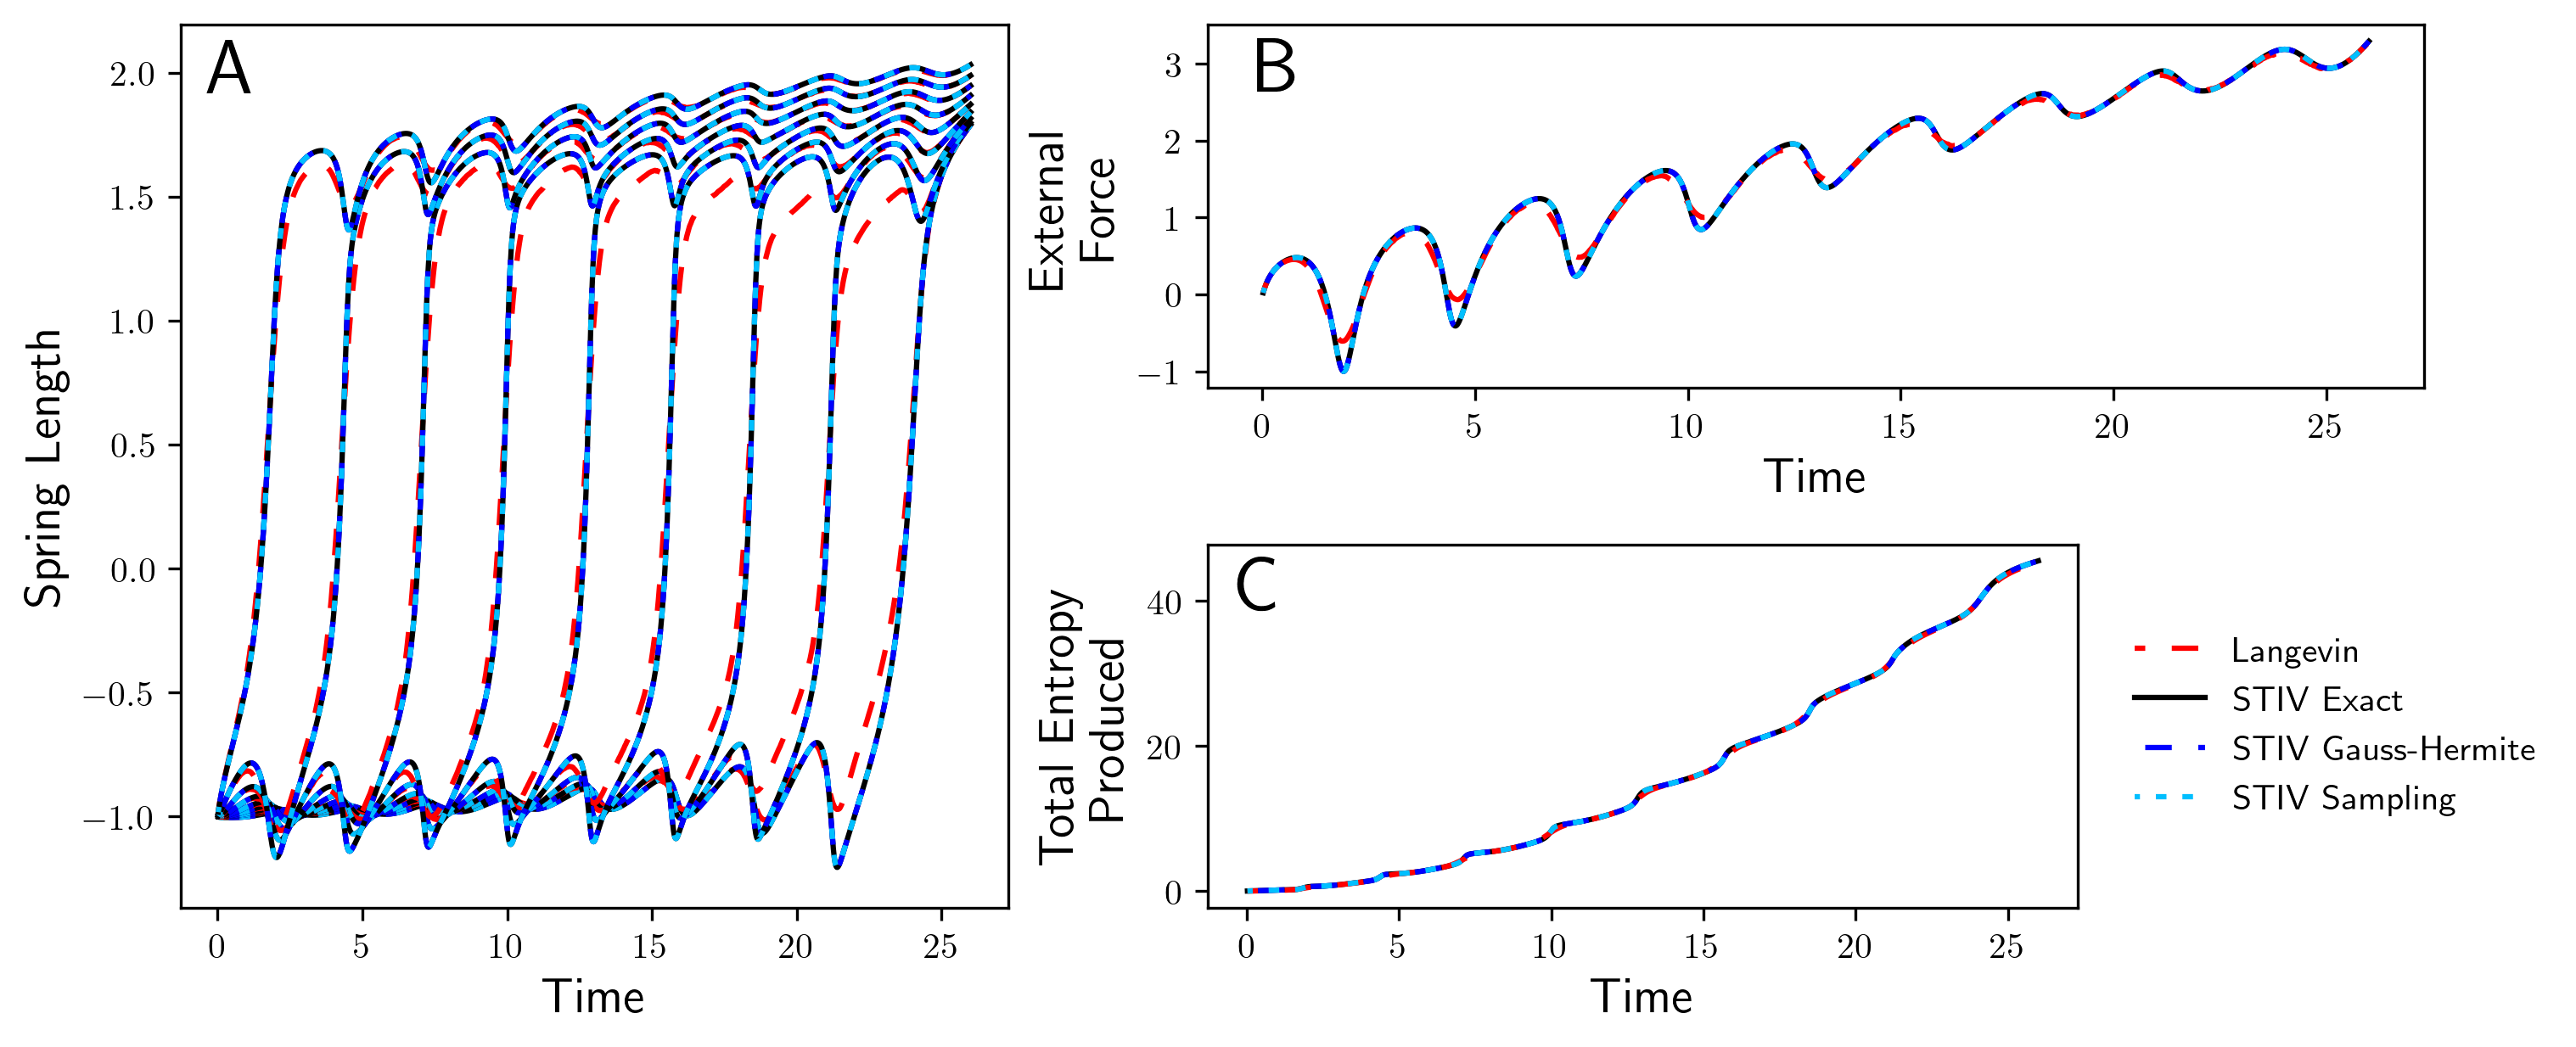

In [37]:
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D



def diff(m,l):
  em = np.zeros(m.shape[0]+2)
  em = em.at[1:-1].set(m)
  em = em.at[-1].set(l)
  return em[1:] - em[:-1]

alldms = [vmap(diff)(allms[i],sims[i].ell(allts[i])) for i in range(len(sims))]

fig = plt.figure(figsize = (10,4),dpi = 300,constrained_layout = True)
gsFig = fig.add_gridspec(2,7)
ax1 = fig.add_subplot(gsFig[:,:3])
ax2 = fig.add_subplot(gsFig[0,3:7])
ax3 = fig.add_subplot(gsFig[1,3:6])
axExtra = fig.add_subplot(gsFig[1,-1])
axExtra.set_axis_off()

ax = [ax1,ax2,ax3]

for i in range(alldms[0].shape[-1]):
    for j in range(len(sims)):
      ax[0].plot(allts[j],alldms[j][:,i],color = colors[j],linestyle = styles[j])
for j in range(len(sims)):
  #ax[1].plot(allts[j],allfExs[j],color = colors[j],linestyle = styles[j],label = labels[j],zorder = zorders[j])
  ax[1].plot(allts[j],allfExs[j],color = colors[j],linestyle = styles[j],zorder = zorders[j])
  ax[2].plot(allts[j],(allts[j][1] - allts[j][0])*(np.cumsum(allents[j]) - allents[j][0]),label = labels[j],color = colors[j],linestyle = styles[j],zorder = zorders[j])#,label = labels[j])
#ax[2].plot(tsPF,(tsPF[1] - tsPF[0])*(np.cumsum(entPFStrain) - entPFPhase[0]),linestyle = styles[-2],label = labels[-2],color = colors[-2],zorder = zorders[-2])
#ax[2].plot(tsPF,(tsPF[1] - tsPF[0])*(np.cumsum(entPFPhase) - entPFPhase[0]),linestyle = styles[-1],label = labels[-1],color = colors[-1],zorder = zorders[-1])

mlines = []
for j in range(len(labels)):
    mlines.append(Line2D([0],[0],linestyle = styles[j],label = labels[j],color = colors[j]))

axExtra.legend(mlines,labels,fontsize=  fs-4,loc = "center",bbox_to_anchor = (0.5,0.5),ncols = 1,frameon = False,columnspacing = .3)
#ax[2].legend(fontsize = fs-4,frameon = False)
#ax[2].set_ylim([-5,55])
for o in ax:
    o.set_xlabel("Time",fontsize = fs)
ax[0].set_ylabel("Spring Length",fontsize = fs)
ax[1].set_ylabel("External\nForce", fontsize = fs)
ax[2].set_ylabel("Total Entropy\nProduced",fontsize = fs)
#ax[0].set_title("Spring Lengths",fontsize = fs)
#ax[1].set_title("External Force",fontsize = fs)
#ax[2].set_title("Total Entropy Produced",fontsize = fs)
ax[0].text(0.06,0.945,"A",fontsize = fs+8,ha = "center",va = "center",transform = ax[0].transAxes)
ax[1].text(0.06,0.87,"B",fontsize = fs+8,ha = "center",va = "center",transform = ax[1].transAxes)
ax[2].text(0.06,0.87,"C",fontsize = fs+8,ha = "center",va = "center",transform = ax[2].transAxes)
#plt.tight_layout()
plt.savefig("Fig2.pdf")
plt.show()